In [15]:
import numpy as np
from numpy import cos, sin, pi
import matplotlib.pyplot as plt
from nest import overlap_try as overlap
from astropy.cosmology import Planck15
from scipy.integrate import simps

cosmo = Planck15
H0 =  cosmo.H0.to('1/s').value

plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.family'] = 'serif'

\begin{equation*}
N_{\rm AA} (f,A,P) = \frac{1}{2} \left\{ 4\left[1+ \cos\left( \frac{f}{f_*}\right) + \cos^2\left( \frac{f}{f_*}\right) \right] P_{\rm acc}(f,A)  + \left[ 2+ \cos\left( \frac{f}{f_*}\right)  \right]P_{\rm IMS}(f,P)\right\}\,.
\end{equation*}


\begin{equation*}
P_{\rm IMS}(f,P) = \frac{P^2}{L^2} \frac{\rm{pm}^2}{\rm{Hz}} \left[ 1+\left( \frac{2 \rm{mHz}}{f} \right)^4 \right]\,,
\end{equation*}

\begin{equation*}
P_{\rm acc}(f,A) = \frac{A^2}{L^2} \frac{\rm{fm}^2}{\rm{s}^4\rm{Hz}} \left[ 1+\left( \frac{0.4 \rm{mHz}}{f} \right)^2 \right]\left[ 1+\left( \frac{f}{8 \rm{mHz}} \right)^4 \right] \left(\frac{1}{2\pi f}\right)^4\,.
\end{equation*}

In [33]:
L = 2.5*1e9 #m
c = 3*1e8 #m/s
P = 15
A = 3
pm = 1e-12 #m
fm = 1e-15 #m


def Poms(P, f, pm, c):
    return P*P * pm*pm * ( 1 + (2*1e-3/f)**4 )* (2*np.pi * f /c)**2

def Pacc(A, fm, c, f):
    return A*A * fm*fm * ( 1 + (0.4*1e-3/f)**2 ) * (1 + (f/(8*1e-3))**4 ) * (1/(2* np.pi*f))**4 * (2* np.pi* f /c)**2

def Pn_auto(f, P, A, L): #noise auto-correlation
    return 16 * (np.sin(2*np.pi*f*L/c))**2 * ( Poms(P, f, pm, c) + Pacc(A, fm, c, f)*( 3 + np.cos(4*np.pi*f*L/c) )  )

def Pn_cross(f, P, A, L): #noise cross-correlation
    return -8 * (np.sin(2*np.pi*f*L/c))**2 * np.cos(2*np.pi*f*L/c) *( Poms(P, f, pm, c) + 4*Pacc(A, fm, c, f) )

def R_auto(f, c, L): #response function auto-correlation
    return 16 * (np.sin(2*np.pi*f*L/c))**2 * (3/10) * (2*np.pi*f*L/c)**2 /(1+ 0.6*(2*np.pi*f*L/c)**2)

def R_cross(f, c, L): #response function cross-correlation
    return 16 * (np.sin(2*np.pi*f*L/c))**2 *  (2*np.pi*f*L/c)**2 * (  ( (3/10) * (2*np.pi*f*L/c)**2 /(1+ 0.6*(2*np.pi*f*L/c)**2)) - ( (9/20) * (2*np.pi*f*L/c)**2 /(1+ 0.7*(2*np.pi*f*L/c)**2)) )

def P_AA(f, P, A, L):
    return Pn_auto(f, P, A, L) - Pn_cross(f, P, A, L)

def P_TT(f, P, A, L):
    return Pn_auto(f, P, A, L) + 2*Pn_cross(f, P, A, L)

def R_AA(f, c, L):
    return R_auto(f, c, L) - R_cross(f, c, L)

def R_TT(f, c, L):
    return R_auto(f, c, L) + 2*R_cross(f, c, L)

def LISA_noise_AET(f, channel, foreground=False):
    L = 2.5*1e9 #m
    c = 3*1e8 #m/s
    P = 15
    A = 3
    pm = 1e-12 #m
    fm = 1e-15 #m
    
    def Sn_foreground(f):
        exp = np.exp(-f**0.138 -221*f* np.sin(521*f) )
        tanh = 1+ np.tanh(1680*(0.00113 -f))
        return 1.80*1e-44* (f**(-7/3)) * exp * tanh
    
    if foreground==True:
        if channel=='AA' or channel=='EE':
            return P_AA(f, P, A, L)/R_AA(f, c, L) + Sn_foreground(f)
        elif channel=='TT':
            return P_TT(f, P, A, L)/R_TT(f, c, L) + Sn_foreground(f)
        else:
            print('Channel not found')
            return 0
        
    else:
        if channel=='AA' or channel=='EE':
            return P_AA(f, P, A, L)/R_AA(f, c, L)
        elif channel=='TT':
            return P_TT(f, P, A, L)/R_TT(f, c, L)
        else:
            print('Channel not found')
            return 0
 

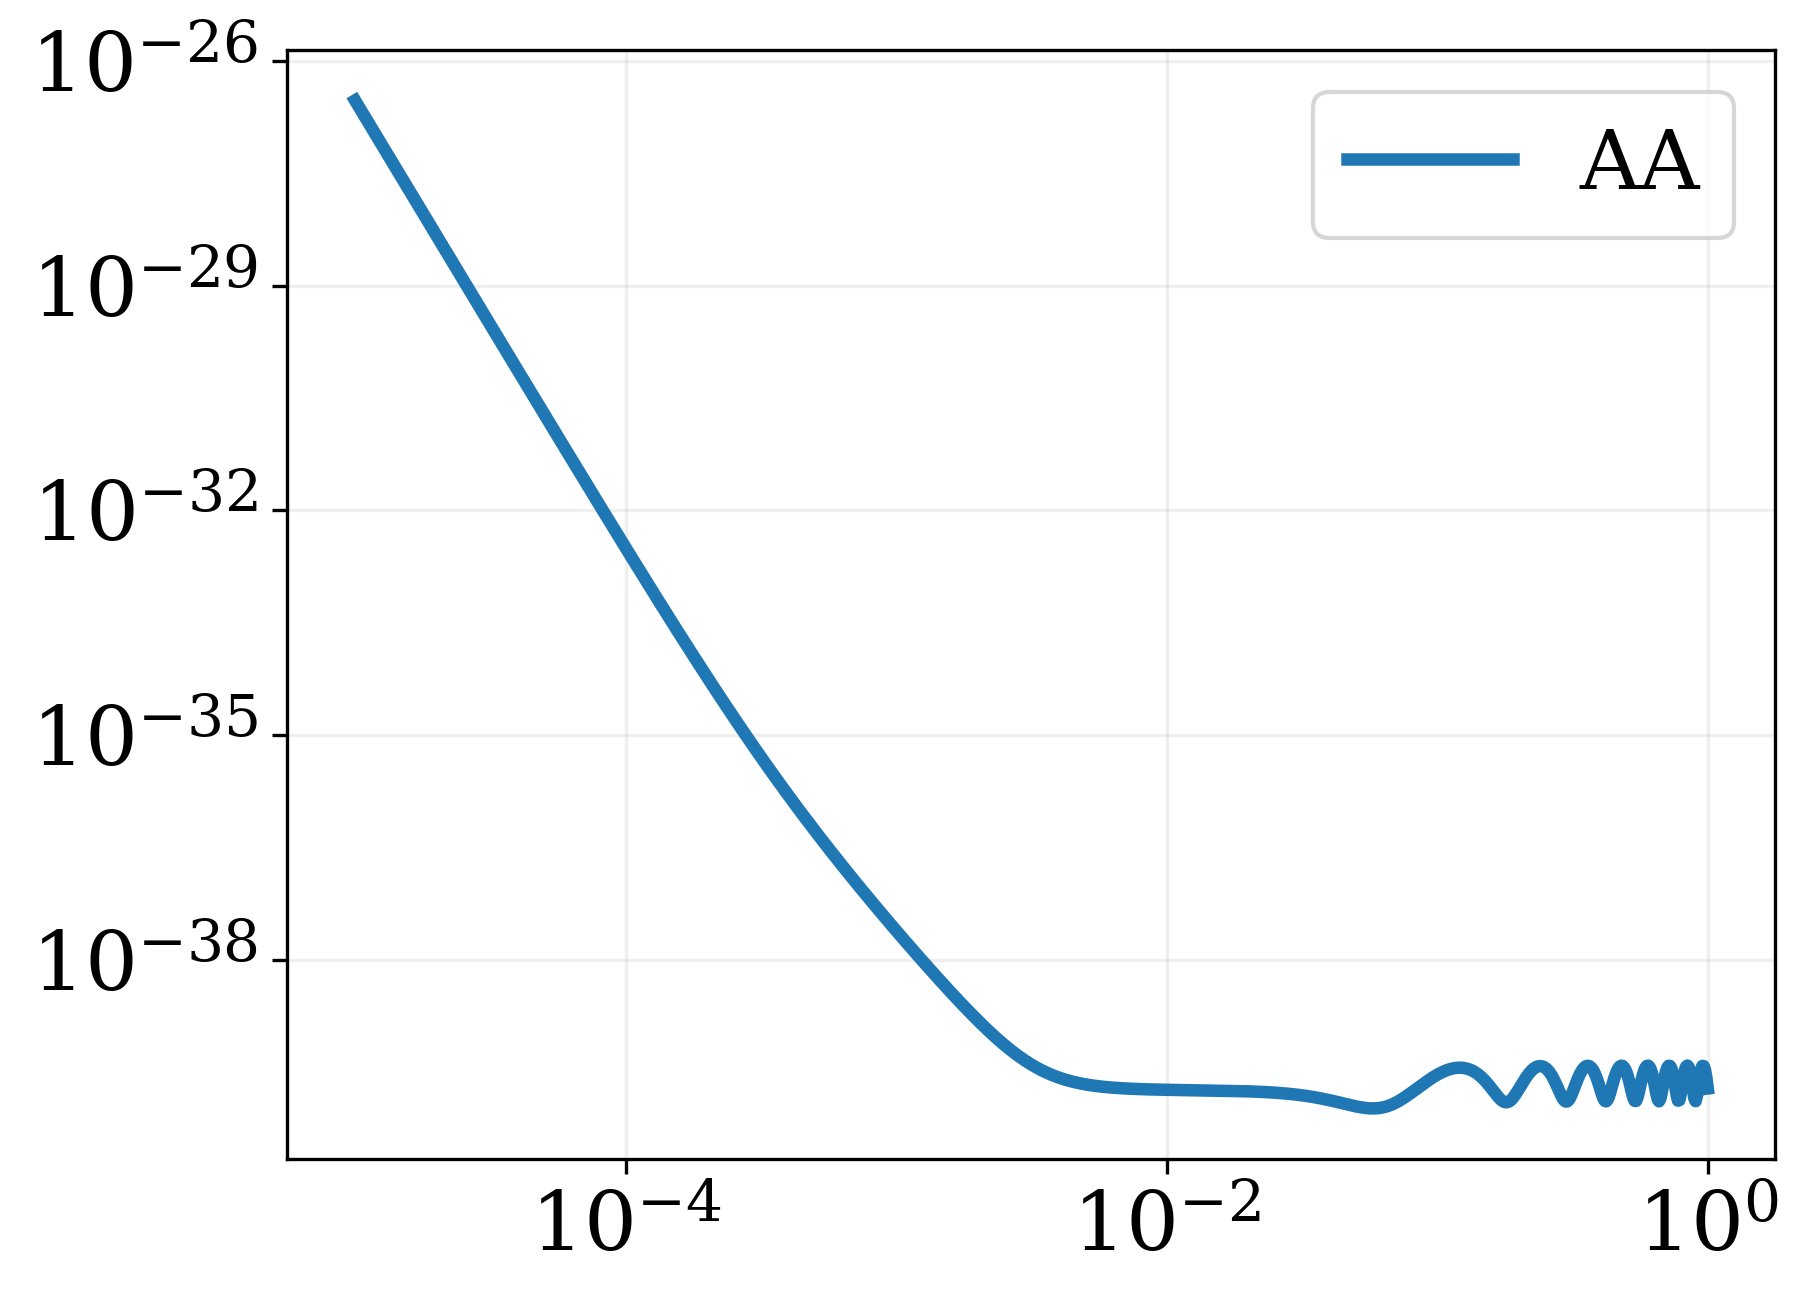

In [34]:
f = np.logspace(-5, 0, 1000)

lisa_noise_AA = LISA_noise_AET(f, 'AA', foreground=False)

plt.plot(f, lisa_noise_AA, label='AA')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.2, which='both')
plt.legend()
plt.show()


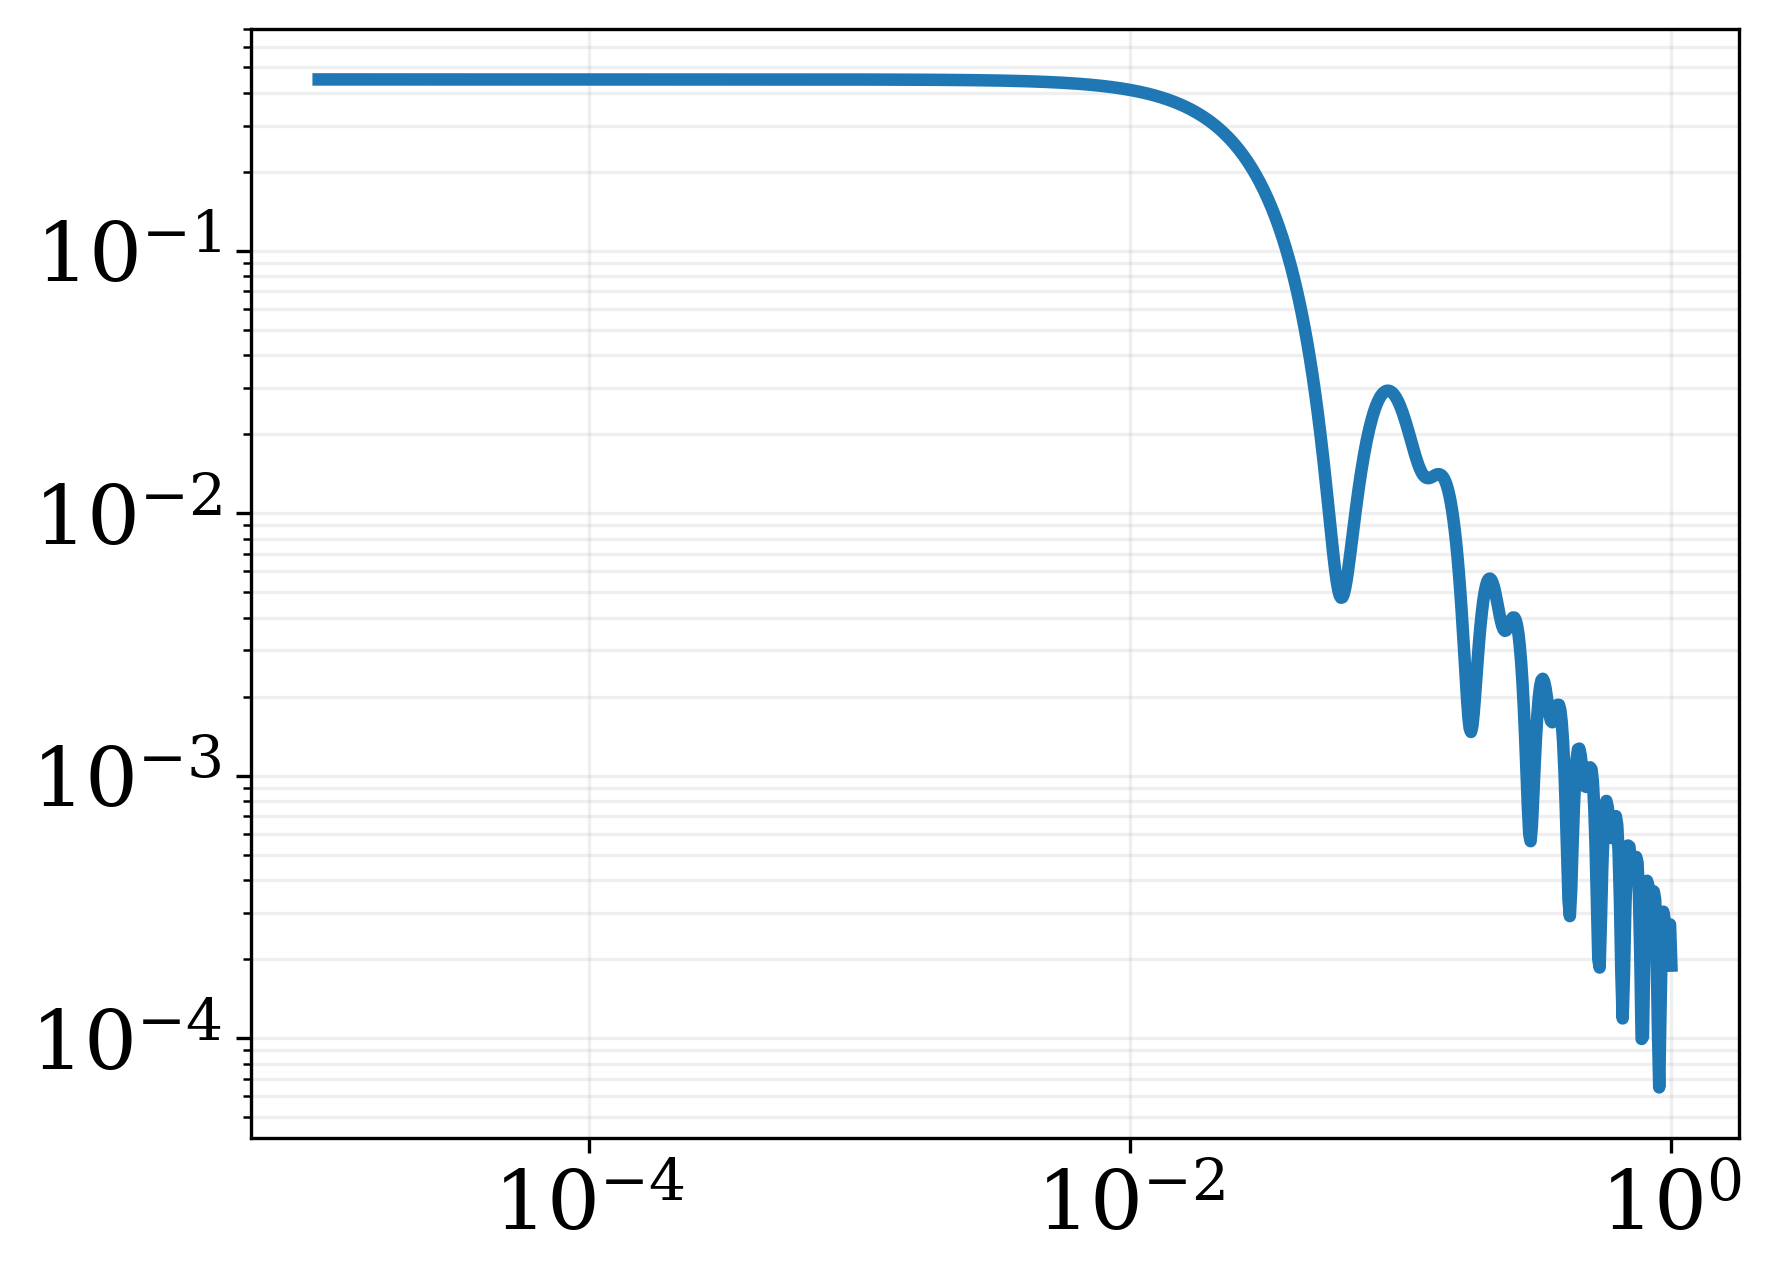

In [35]:
XX = overlap.overlap('LISA 1', 'LISA 1', f, 0, 't')
XY = overlap.overlap('LISA 1', 'LISA 2', f, 0, 't')

orfIJ = (np.array(XX) - np.array(XY))

plt.plot(f, orfIJ)
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.2, which='both')
plt.show()


In [36]:
def Omega_beta(f, fref, snr, Tobs, beta, orf, Ni, Nj):
    Tobs = Tobs * 365 * 24 * 3600
    integrand = ((f/fref)**(2*beta)) * (orf**2) / (f**6) / (Ni) / (Nj)
    integral = simps(integrand, f)
    return 10 * (np.pi**2) * snr /(3*(H0**2)) / (integral**(0.5))/ np.sqrt(2* Tobs)

def Omega_GW(f, fref, snr, Tobs, beta, orf, Ni, Nj):
    return Omega_beta(f, fref, snr, Tobs, beta, orf, Ni, Nj) * ((f/fref)**(beta))

def all_Omega_GW(f, fref, snr, Tobs, beta_min, beta_max, orf, Ni, Nj):
    beta = np.linspace(beta_min, beta_max, 1000)
    Omega = []
    for i in range(len(beta)):
        Omega.append(Omega_GW(f, fref, snr, Tobs, beta[i], orf, Ni, Nj))     
    return beta, np.array(Omega)

def PLS(f, fref, snr, Tobs, beta_min, beta_max, orf, Ni, Nj):
    beta, Omega = all_Omega_GW(f, fref, snr, Tobs, beta_min, beta_max, orf, Ni, Nj)
    print(Omega.shape)
    pls = np.zeros(len(f))
    for i in range(len(f)):
        pls[i] = np.max(Omega[:,i])
    return pls



/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_67316/3109131134.py:4: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(integrand, f)


(1000, 1000)


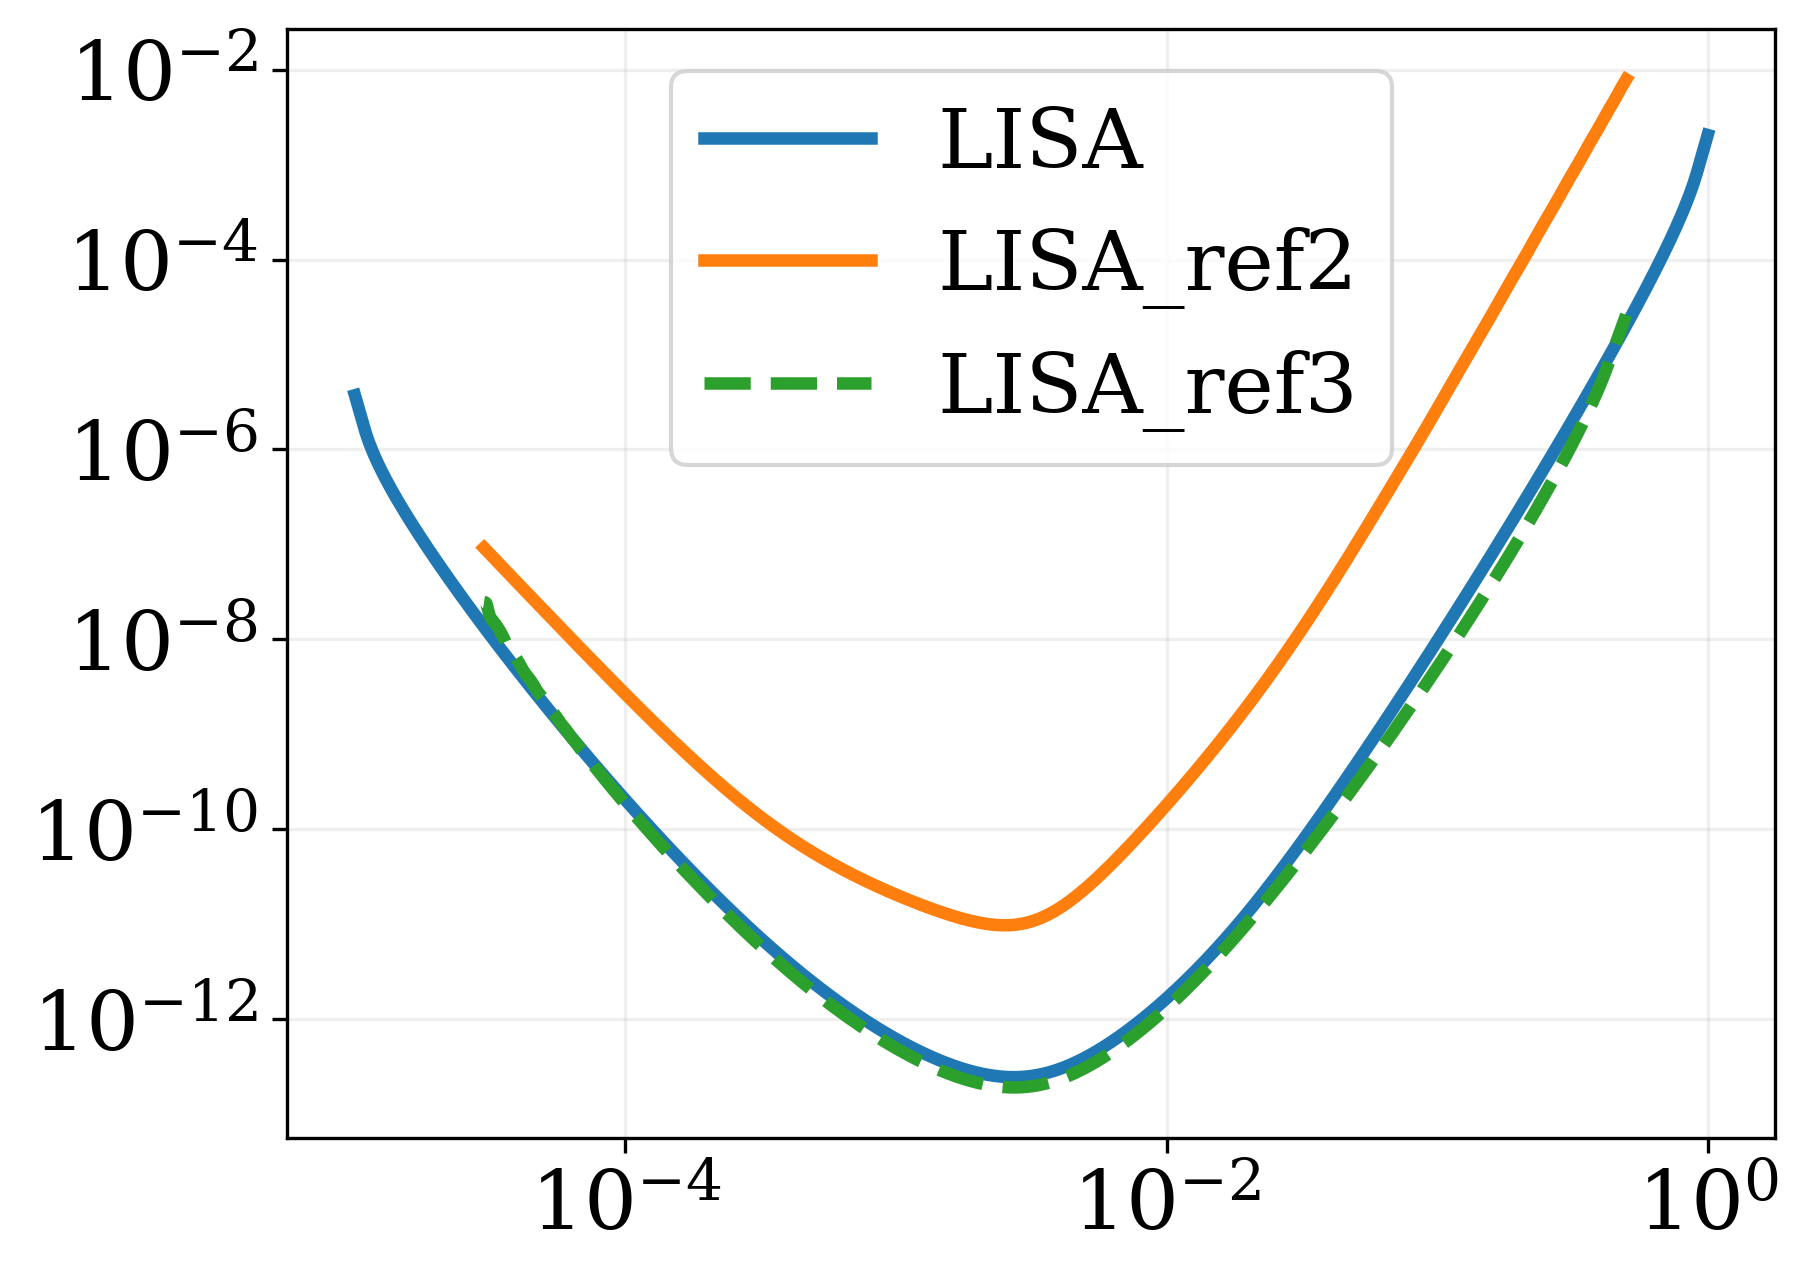

In [44]:
fref= c/(2*np.pi*L)
snr = 1
Tobs = 3
beta_min = -10
beta_max= 10

# Ni = NAA(A, P, fstar, f, fm, c)
# Nj = NAA(A, P, fstar, f, fm, c)

# f_re, psd_ref = np.loadtxt('LISA_sens.txt', unpack=True, usecols=(0, 1))

Ni = LISA_noise_AET(f, 'AA', foreground=False)
Nj = LISA_noise_AET(f, 'AA', foreground=False)


pls = PLS(f, fref, snr, Tobs, beta_min, beta_max, orfIJ, Ni, Nj)

f_ref, PLS_ref1, PLS_ref2, PLS_ref3 = np.loadtxt('LISA_sens.txt', unpack=True, usecols=(0, 1, 2, 3))

plt.plot(f, pls, label='LISA')
plt.plot(f_ref, PLS_ref2, label='LISA_ref2')
plt.plot(f_ref, PLS_ref3, label='LISA_ref3', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.2, which='both')
legend = plt.legend()
plt.show()
